# Academic Journal Summarization Modeling - Model Baseline and Fine Tuning

## Setup

In [ ]:
!pip install -q sentencepiece

In [ ]:
!pip install -q transformers

In [ ]:
!pip install -q evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 19.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.1/316.1 kB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 15.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.3.1+cu121 requires nvidia-cublas-cu12==12.1.3.1; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.1+cu121 requires nvidia-cuda-cupti-

In [ ]:
!pip install -q rouge_score

  Preparing metadata (setup.py) ... done


In [ ]:
# Standard libraries
import os
import pandas as pd
import matplotlib.pyplot as plt

# Datset
from datasets import Dataset

# For counting and checkpoints
import pytz
from datetime import datetime

# Modeling
import tensorflow as tf
import nltk
#import torch
#import accelerate

from sklearn.model_selection import train_test_split

from transformers import PegasusTokenizer, TFPegasusForConditionalGeneration, DataCollatorForSeq2Seq #, Seq2SeqTrainingArguments, Seq2SeqTrainer

import evaluate

In [ ]:
# Colab
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## Data

In [ ]:
# Woojae's path
df = pd.read_csv('/content/drive/MyDrive/DATASCI266/266 Project/envisci_articles.csv')
#df = pd.read_csv('/content/drive/MyDrive/266_Project/envisci_articles.csv')

# Brendan's path
#df = pd.read_csv('/content/drive/MyDrive/DATASCI266/envisci_articles.csv')

# Summer's path
#df = pd.read_csv('/content/drive/MyDrive/266_Project/envisci_articles.csv')

df.head()

,abstract,full_text
0,Ice nucleation is a process of great relevance...,ordinated water molecules. Ice nucleation fro...
1,The ability of a red tide species to take up n...,INTRODUCTION Red tides or harmful algal bloom...
2,Recent advances in science and technology radi...,RA is a systemic disorder characterized by inf...
3,Secondary ion mass spectrometry (SIMS) is a pr...,Introduction Secondary ion mass spectrometry ...
4,Citizen-science databases have been used to de...,aims in this study were to illustrate the effe...


In [ ]:
# Check null
print(df.isna().sum())

# Shape
df.shape

abstract     0
full_text    0
dtype: int64


(4160, 2)

In [ ]:
# Split data
train, test = train_test_split(df, test_size=0.2, random_state=1)
print("Train:", train.shape)
print("Test:", test.shape)

Train: (3328, 2)
Test: (832, 2)


## Baseline

In [ ]:
# Index range
beginning_range_index = 470
ending_range_index = 480

# Output paths - Baseline
#LOCAL_OUTPUT_CSV_PATH = './drive/MyDrive/DATASCI266/266 Project/model_baseline_files/'
LOCAL_OUTPUT_CSV_PATH = './drive/MyDrive/266_Project/model_baseline_files/'

In [ ]:
# Initialize the Pegasus tokenizer and model

model = TFPegasusForConditionalGeneration.from_pretrained("google/pegasus-xsum")
tokenizer = PegasusTokenizer.from_pretrained("google/pegasus-xsum")

#model = TFPegasusForConditionalGeneration.from_pretrained("google/pegasus-cnn_dailymail", from_pt=True)
#tokenizer = PegasusTokenizer.from_pretrained("google/pegasus-cnn_dailymail", from_pt=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
All model checkpoint layers were used when initializing TFPegasusForConditionalGeneration.

Some layers of TFPegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-xsum and are newly initialized: ['final_logits_bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Baseline

def tokenize_text(text):
    inputs = tokenizer(text, return_tensors='tf', truncation=True, padding='max_length', max_length=512)
    return inputs

# Preparing tokenized dataset, grabbing only indices of interest
lst_texts = [tokenize_text(text) for text in test['full_text'][beginning_range_index:ending_range_index]]
ref_text = test['abstract'][beginning_range_index:ending_range_index]

# Generating summaries
count = beginning_range_index

for i, (text, reference) in enumerate(zip(lst_texts, ref_text)):
  # Constants
  data = []
  max_len = int(150)
  min_len = int(150/2)
  no_repeat_ngram = 4
  est = pytz.timezone('US/Eastern')

  # Set Start Timestamps
  utc_start = datetime.now(pytz.utc)
  est_start = utc_start.astimezone(est)
  print('----------')
  print(f'Start Time: {est_start}')

  # Create Filename
  file_name = f'baseline_{beginning_range_index}_to_{ending_range_index}_maxlen_{max_len}_norepeatngram_{no_repeat_ngram}_index_{count}.csv'
  output_path = LOCAL_OUTPUT_CSV_PATH + file_name

  # Calculate Summarization Params

  summaries = model.generate(text['input_ids']
                              , early_stopping=True
                              , no_repeat_ngram_size = no_repeat_ngram
                              , attention_mask=text['attention_mask']
                              , max_new_tokens = max_len
                              , min_length = min_len
  )

  output = tokenizer.batch_decode(summaries, skip_special_tokens=True)

  # Write to CSV
  data.append({'GeneratedText':output, 'ReferenceText':reference})
  df = pd.DataFrame(data)
  df.to_csv(output_path, index=False)

  # Set End Timestamps
  utc_end = datetime.now(pytz.utc)
  est_end = utc_end.astimezone(est)
  time_difference = est_end - est_start
  seconds = time_difference.seconds
  hours = seconds // 3600
  minutes = (seconds % 3600) // 60
  seconds = seconds % 60
  formatted_difference = f"{hours:02}:{minutes:02}:{seconds:02}"

  print(f'File Name: {file_name}. Time Taken: {formatted_difference}')

  count = count + 1

----------
Start Time: 2024-07-28 19:42:16.066254-04:00
File Name: baseline_480_to_490_maxlen_150_norepeatngram_4_index_480.csv. Time Taken: 00:03:26
----------
Start Time: 2024-07-28 19:45:42.552867-04:00
File Name: baseline_480_to_490_maxlen_150_norepeatngram_4_index_481.csv. Time Taken: 00:03:12
----------
Start Time: 2024-07-28 19:48:55.364784-04:00
File Name: baseline_480_to_490_maxlen_150_norepeatngram_4_index_482.csv. Time Taken: 00:03:11
----------
Start Time: 2024-07-28 19:52:07.345003-04:00
File Name: baseline_480_to_490_maxlen_150_norepeatngram_4_index_483.csv. Time Taken: 00:02:59
----------
Start Time: 2024-07-28 19:55:07.075519-04:00
File Name: baseline_480_to_490_maxlen_150_norepeatngram_4_index_484.csv. Time Taken: 00:03:17
----------
Start Time: 2024-07-28 19:58:24.241357-04:00
File Name: baseline_480_to_490_maxlen_150_norepeatngram_4_index_485.csv. Time Taken: 00:03:14
----------
Start Time: 2024-07-28 20:01:38.453492-04:00
File Name: baseline_480_to_490_maxlen_150_no

In [ ]:
# For testing with examples

#baseline_output = pd.read_csv('/content/drive/MyDrive/DATASCI266/266 Project/model_baseline_files/baseline_0_to_50_maxlen_150_norepeatngram_4_index_0.csv', usecols = [0])
#baseline_reference = pd.read_csv('/content/drive/MyDrive/DATASCI266/266 Project/model_baseline_files/baseline_0_to_50_maxlen_150_norepeatngram_4_index_0.csv', usecols = [1])
baseline_output = pd.read_csv('/content/drive/MyDrive/266_Project/model_baseline_files/baseline_0_to_50_maxlen_150_norepeatngram_4_index_0.csv', usecols = [0])
baseline_reference = pd.read_csv('/content/drive/MyDrive/266_Project/model_baseline_files/baseline_0_to_50_maxlen_150_norepeatngram_4_index_0.csv', usecols = [1])

rouge = evaluate.load('rouge')
baseline_result = rouge.compute(predictions=[baseline_output.iloc[0, 0]], references=[baseline_reference.iloc[0, 0]])

print('\n-----BASELINE-----\n')
print(baseline_output.iloc[0, 0])
print(baseline_reference.iloc[0, 0])

print(baseline_result)


-----BASELINE-----

['Birdhouse is a Python-based platform for the processing of climate data and is part of the System for the Study of Earth and Climate (WPS) which is funded by the European Union (EU) and runs under the auspices of the International Union for the Conservation of Nature (IUCN) and the United Nations Framework Convention on Climate Change (UNFCCC) and is co-funded by the Canadian government.']
Birdhouse is a collaborative project open for the community to participate.It is a software framework containing a collection of Web Processing Services (WPS).The deployed algorithms are focusing on Earth Systems and environmental data processing with the philosophy of streamlining the software development and deployment.By supporting climate, earth observation and biodiversity data and processes, Birdhouse can be used in a wide array of Earth sciences projects and workflows.The core benefit of this project is to allow the seamless use of climate services developed by a diverse

In [ ]:
# # Evaluation (Need to update so it takes eval from ALL output and ref, not just of this batch)
# rouge = evaluate.load('rouge')
# result = rouge.compute(predictions=output, references=[ref_text])

# print(result)

## Fine-tuning Model

In [ ]:
# # Convert to Hugging Face dataset
# train_df = Dataset.from_pandas(train)
# test_df = Dataset.from_pandas(test)

# Train & Val
train_df, val_df = train_test_split(train, test_size=0.2, random_state=1)

In [ ]:
# Initialize the Pegasus tokenizer and model

model = TFPegasusForConditionalGeneration.from_pretrained("google/pegasus-xsum")
tokenizer = PegasusTokenizer.from_pretrained("google/pegasus-xsum")

#model = TFPegasusForConditionalGeneration.from_pretrained("google/pegasus-cnn_dailymail", from_pt=True)
#tokenizer = PegasusTokenizer.from_pretrained("google/pegasus-cnn_dailymail", from_pt=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.39k [00:00<?, ?B/s]

tf_model.h5:   0%|          | 0.00/2.28G [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFPegasusForConditionalGeneration.

Some layers of TFPegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-xsum and are newly initialized: ['final_logits_bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


generation_config.json:   0%|          | 0.00/259 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/87.0 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/1.91M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/65.0 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.52M [00:00<?, ?B/s]

In [ ]:
# Tokenization function for fine-tuning
def ft_preprocess(text):
    inputs = tokenizer(text['full_text'].tolist(), return_tensors='tf', truncation=True, padding='max_length', max_length=256)
    targets = tokenizer(text['abstract'].tolist(), return_tensors='tf', truncation=True, padding='max_length', max_length=256)

    # with tokenizer.as_target_tokenizer():
    #     targets = tokenizer(text['abstract'].tolist(), return_tensors='tf', truncation=True, padding='max_length', max_length=512)

    inputs['labels'] = targets['input_ids']

    # return inputs, targets['input_ids']
    return inputs

# Tokenize datasets
train_df_tokenized = ft_preprocess(train_df)
val_df_tokenized = ft_preprocess(val_df)

# # Tokenize datasets
# train_inputs, train_labels = ft_preprocess(train_df)
# val_inputs, val_labels = ft_preprocess(val_df)

In [ ]:
train_df_tokenized['input_ids'] = tf.cast(train_df_tokenized['input_ids'], tf.int32)
train_df_tokenized['attention_mask'] = tf.cast(train_df_tokenized['attention_mask'], tf.int32)
train_df_tokenized['labels'] = tf.cast(train_df_tokenized['labels'], tf.int32)
val_df_tokenized['input_ids'] = tf.cast(val_df_tokenized['input_ids'], tf.int32)
val_df_tokenized['attention_mask'] = tf.cast(val_df_tokenized['attention_mask'], tf.int32)
val_df_tokenized['labels'] = tf.cast(val_df_tokenized['labels'], tf.int32)

In [ ]:
# Convert to tf.data.Dataset
train_dataset = tf.data.Dataset.from_tensor_slices((dict(train_df_tokenized), train_df_tokenized['labels'])).batch(1)
val_dataset = tf.data.Dataset.from_tensor_slices((dict(val_df_tokenized), val_df_tokenized['labels'])).batch(1)

In [ ]:
# Data collator
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model, return_tensors='tf')

In [ ]:
# # Training (PyTorch)

# batch_size = 4
# num_train_epochs = 2
# learning_rate = 0.00005

# training_args = Seq2SeqTrainingArguments(
#     output_dir="./checkpoint_results",
#     evaluation_strategy="epoch",
#     learning_rate=learning_rate,
#     per_device_train_batch_size=batch_size,
#     per_device_eval_batch_size=batch_size,
#     weight_decay=0.01,
#     save_total_limit=3,
#     num_train_epochs=num_train_epochs,
#     predict_with_generate=True,
# )

# # Initialize trainer
# trainer = Seq2SeqTrainer(
#     model=model,
#     args=training_args,
#     train_dataset=train_hf_tokenized,
#     eval_dataset=val_hf_tokenized,
#     tokenizer=tokenizer,
#     data_collator=data_collator,
# )

# with tf.device('/GPU:0'):  # Place operations on the GPU
#     trainer.train()

In [ ]:
# Fine-tuning model path
# Woojae's path
LOCAL_MODEL_PATH = './drive/MyDrive/DATASCI266/266 Project'
#LOCAL_MODEL_PATH = './drive/MyDrive/266_Project'

In [ ]:
# Training (Tensorflow)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.00005)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# Define train and validation steps
@tf.function
def train_step(inputs, labels):
    with tf.GradientTape() as tape:
        outputs = model(inputs, training=True)
        logits = outputs.logits
        loss = loss_fn(labels, logits)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

@tf.function
def val_step(inputs, labels):
    outputs = model(inputs, training=False)
    logits = outputs.logits
    loss = loss_fn(labels, logits)
    return loss

# Training
num_epochs = 1

for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")

    # Training
    train_count = 1
    train_loss = 0
    for batch in train_dataset:

        print(f"training example {train_count} / {len(train_dataset)}")

        inputs, labels = batch
        loss = train_step(inputs, labels)
        train_loss += loss

        train_count += 1

    train_loss /= len(train_dataset)

    # Validation
    val_count = 1
    val_loss = 0
    for batch in val_dataset:

        print(f"validation example {val_count} / {len(val_dataset)}")

        inputs, labels = batch
        loss = val_step(inputs, labels)
        val_loss += loss

        val_count += 1

    val_loss /= len(val_dataset)

    print(f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

model.save_pretrained(LOCAL_MODEL_PATH + '/finetuned')
tokenizer.save_pretrained(LOCAL_MODEL_PATH + '/finetuned')

Epoch 1/1
training example 1 / 2662
training example 2 / 2662
training example 3 / 2662
training example 4 / 2662
training example 5 / 2662
training example 6 / 2662
training example 7 / 2662
training example 8 / 2662
training example 9 / 2662
training example 10 / 2662
training example 11 / 2662
training example 12 / 2662
training example 13 / 2662
training example 14 / 2662
training example 15 / 2662
training example 16 / 2662
training example 17 / 2662
training example 18 / 2662
training example 19 / 2662
training example 20 / 2662
training example 21 / 2662
training example 22 / 2662
training example 23 / 2662
training example 24 / 2662
training example 25 / 2662
training example 26 / 2662
training example 27 / 2662
training example 28 / 2662
training example 29 / 2662
training example 30 / 2662
training example 31 / 2662
training example 32 / 2662
training example 33 / 2662
training example 34 / 2662
training example 35 / 2662
training example 36 / 2662
training example 37 / 2662


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 64, 'num_beams': 8, 'length_penalty': 0.6, 'forced_eos_token_id': 1}


validation example 666 / 666
Train Loss: 3.9696, Val Loss: 2.7758


('./drive/MyDrive/266_Project/finetuned/tokenizer_config.json',
 './drive/MyDrive/266_Project/finetuned/special_tokens_map.json',
 './drive/MyDrive/266_Project/finetuned/spiece.model',
 './drive/MyDrive/266_Project/finetuned/added_tokens.json')

## Fine-tuned Model Summarization

In [ ]:
# Index range
beginning_range_index = 553
ending_range_index = 600

# Output paths - Fine tuned
# Woojae's path
LOCAL_OUTPUT_CSV_PATH = './drive/MyDrive/DATASCI266/266 Project/model_fine_tuned_files/'
#LOCAL_OUTPUT_CSV_PATH = './drive/MyDrive/266_Project/model_fine_tuned_files/'
# Summer's path
#LOCAL_OUTPUT_CSV_PATH = './drive/MyDrive/266_Project/model_fine_tuned_files/'


In [ ]:
# Fine-tuned Pegasus model and tokenizer
model = TFPegasusForConditionalGeneration.from_pretrained(LOCAL_MODEL_PATH + '/finetuned')
tokenizer = PegasusTokenizer.from_pretrained(LOCAL_MODEL_PATH + '/finetuned')

All model checkpoint layers were used when initializing TFPegasusForConditionalGeneration.

All the layers of TFPegasusForConditionalGeneration were initialized from the model checkpoint at ./drive/MyDrive/DATASCI266/266 Project/finetuned.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFPegasusForConditionalGeneration for predictions without further training.


In [ ]:
# Fine-tuned

def tokenize_text(text):
    inputs = tokenizer(text, return_tensors='tf', truncation=True, padding='max_length', max_length=512)
    return inputs

# Preparing tokenized dataset, grabbing only indices of interest
lst_texts = [tokenize_text(text) for text in test['full_text'][beginning_range_index:ending_range_index]]
ref_text = test['abstract'][beginning_range_index:ending_range_index]

# Generating summaries
count = beginning_range_index

for i, (text, reference) in enumerate(zip(lst_texts, ref_text)):
  # Constants
  data = []
  max_len = int(150)
  min_len = int(150/2)
  no_repeat_ngram = 4
  est = pytz.timezone('US/Eastern')

  # Set Start Timestamps
  utc_start = datetime.now(pytz.utc)
  est_start = utc_start.astimezone(est)
  print('----------')
  print(f'Start Time: {est_start}')

  # Create Filename
  file_name = f'finetuned_{beginning_range_index}_to_{ending_range_index}_maxlen_{max_len}_norepeatngram_{no_repeat_ngram}_index_{count}.csv'
  output_path = LOCAL_OUTPUT_CSV_PATH + file_name

  # Calculate Summarization Params

  summaries = model.generate(text['input_ids']
                              , early_stopping=True
                              , no_repeat_ngram_size = no_repeat_ngram
                              , attention_mask=text['attention_mask']
                              , max_new_tokens = max_len
                              , min_length = min_len
  )

  output = tokenizer.batch_decode(summaries, skip_special_tokens=True)

  # Write to CSV
  data.append({'GeneratedText':output, 'ReferenceText':reference})
  df = pd.DataFrame(data)
  df.to_csv(output_path, index=False)

  # Set End Timestamps
  utc_end = datetime.now(pytz.utc)
  est_end = utc_end.astimezone(est)
  time_difference = est_end - est_start
  seconds = time_difference.seconds
  hours = seconds // 3600
  minutes = (seconds % 3600) // 60
  seconds = seconds % 60
  formatted_difference = f"{hours:02}:{minutes:02}:{seconds:02}"

  print(f'File Name: {file_name}. Time Taken: {formatted_difference}')

  count = count + 1

----------
Start Time: 2024-07-29 17:55:47.595746-04:00
File Name: finetuned_553_to_600_maxlen_150_norepeatngram_4_index_553.csv. Time Taken: 00:01:30
----------
Start Time: 2024-07-29 17:57:17.648499-04:00
File Name: finetuned_553_to_600_maxlen_150_norepeatngram_4_index_554.csv. Time Taken: 00:02:05
----------
Start Time: 2024-07-29 17:59:22.709699-04:00
File Name: finetuned_553_to_600_maxlen_150_norepeatngram_4_index_555.csv. Time Taken: 00:02:04
----------
Start Time: 2024-07-29 18:01:26.922547-04:00
File Name: finetuned_553_to_600_maxlen_150_norepeatngram_4_index_556.csv. Time Taken: 00:02:04
----------
Start Time: 2024-07-29 18:03:31.007858-04:00
File Name: finetuned_553_to_600_maxlen_150_norepeatngram_4_index_557.csv. Time Taken: 00:02:03
----------
Start Time: 2024-07-29 18:05:34.178810-04:00
File Name: finetuned_553_to_600_maxlen_150_norepeatngram_4_index_558.csv. Time Taken: 00:02:03
----------
Start Time: 2024-07-29 18:07:37.551955-04:00
File Name: finetuned_553_to_600_maxlen

In [ ]:
# For testing with examples

#baseline_output = pd.read_csv('/content/drive/MyDrive/DATASCI266/266 Project/model_baseline_files/baseline_0_to_10_maxlen_512_norepeatngram_4_index_0.csv', usecols = [0])
#baseline_reference = pd.read_csv('/content/drive/MyDrive/DATASCI266/266 Project/model_baseline_files/baseline_0_to_10_maxlen_512_norepeatngram_4_index_0.csv', usecols = [1])
baseline_output = pd.read_csv('/content/drive/MyDrive/266_Project/model_baseline_files/baseline_0_to_50_maxlen_150_norepeatngram_4_index_0.csv', usecols = [0])
baseline_reference = pd.read_csv('/content/drive/MyDrive/266_Project/model_baseline_files/baseline_0_to_50_maxlen_150_norepeatngram_4_index_0.csv', usecols = [1])

#finetuned_output = pd.read_csv('/content/drive/MyDrive/DATASCI266/266 Project/model_fine_tuned_files/finetuned_0_to_2_maxlen_512_index_0.csv', usecols = [0])
#finetuned_reference = pd.read_csv('/content/drive/MyDrive/DATASCI266/266 Project/model_fine_tuned_files/finetuned_0_to_2_maxlen_512_index_0.csv', usecols = [1])
finetuned_output = pd.read_csv('/content/drive/MyDrive/266_Project/model_fine_tuned_files/finetuned_0_to_50_maxlen_150_norepeatngram_4_index_0.csv', usecols = [0])
finetuned_reference = pd.read_csv('/content/drive/MyDrive/266_Project/model_fine_tuned_files/finetuned_0_to_50_maxlen_150_norepeatngram_4_index_0.csv', usecols = [1])

rouge = evaluate.load('rouge')
baseline_result = rouge.compute(predictions=[baseline_output.iloc[0, 0]], references=[baseline_reference.iloc[0, 0]])
finetuned_result = rouge.compute(predictions=[finetuned_output.iloc[0, 0]], references=[finetuned_reference.iloc[0, 0]])

print('\n-----BASELINE-----\n')
print(baseline_output.iloc[0, 0])
print(baseline_reference.iloc[0, 0])

print(baseline_result)

print('\n-----FINETUNED-----\n')
print(finetuned_output.iloc[0, 0])
print(finetuned_reference.iloc[0, 0])

print(finetuned_result)


-----BASELINE-----

['Birdhouse is a Python-based platform for the processing of climate data and is part of the System for the Study of Earth and Climate (WPS) which is funded by the European Union (EU) and runs under the auspices of the International Union for the Conservation of Nature (IUCN) and the United Nations Framework Convention on Climate Change (UNFCCC) and is co-funded by the Canadian government.']
Birdhouse is a collaborative project open for the community to participate.It is a software framework containing a collection of Web Processing Services (WPS).The deployed algorithms are focusing on Earth Systems and environmental data processing with the philosophy of streamlining the software development and deployment.By supporting climate, earth observation and biodiversity data and processes, Birdhouse can be used in a wide array of Earth sciences projects and workflows.The core benefit of this project is to allow the seamless use of climate services developed by a diverse

## Evaluation

In [ ]:
def combine_csv_files(folder_path):

    data_frames = []

    for file_name in os.listdir(folder_path):
        if file_name.endswith('.csv'):
            file_path = os.path.join(folder_path, file_name)
            df = pd.read_csv(file_path)
            data_frames.append(df)

    combined_df = pd.concat(data_frames, ignore_index=True)

    return combined_df

In [ ]:
# Combine individual summaries and references into single file

BASELINE_FOLDER_PATH = './drive/MyDrive/DATASCI266/266 Project/model_baseline_files/'
FINETUNED_FOLDER_PATH = './drive/MyDrive/DATASCI266/266 Project/model_fine_tuned_files/'
#BASELINE_FOLDER_PATH = './drive/MyDrive/266_Project/model_baseline_files/'
#FINETUNED_FOLDER_PATH = './drive/MyDrive/266_Project/model_fine_tuned_files/'

baseline_df = combine_csv_files(BASELINE_FOLDER_PATH)
finetuned_df = combine_csv_files(FINETUNED_FOLDER_PATH)

baseline_df.to_csv(BASELINE_FOLDER_PATH + 'baseline_combined.csv', index=False)
finetuned_df.to_csv(FINETUNED_FOLDER_PATH + 'finetuned_combined.csv', index=False)

In [ ]:
def calculate_model_rouge_scores(df):
  # count = 1
  est_start = get_current_time_est()
  rouge = evaluate.load('rouge')

  def compute_rouge_scores(row):
    prediction = row['GeneratedText']
    reference = row['ReferenceText']
    rouge_scores = rouge.compute(predictions=[prediction], references=[reference])
    # count[0] += 1
    # print(f'Example {count[0]} ROUGE scored.')
    return pd.Series(rouge_scores)

  df_rouge = df.apply(compute_rouge_scores, axis=1)
  df = pd.concat([df, df_rouge], axis=1)

  calculate_duration(est_start)

  return df

def calculate_model_meteor_scores(df):
  # count = 1
  est_start = get_current_time_est()
  meteor = evaluate.load('meteor')

  def compute_meteor_scores(row):
    prediction = row['GeneratedText']
    reference = row['ReferenceText']
    rouge_scores = meteor.compute(predictions=[prediction], references=[reference])
    # count[0] += 1
    # print(f'Example {count[0]} METEOR scored.')
    return pd.Series(rouge_scores)

  df_rouge = df.apply(compute_meteor_scores, axis=1)
  df = pd.concat([df, df_rouge], axis=1)

  calculate_duration(est_start)

  return df


def get_current_time_est():
  est = pytz.timezone('US/Eastern')
  utc_start = datetime.now(pytz.utc)
  est_start = utc_start.astimezone(est)
  print(f'Start Time: {est_start}')
  return est_start

def calculate_duration(est_start):
  est = pytz.timezone('US/Eastern')
  utc_end = datetime.now(pytz.utc)
  est_end = utc_end.astimezone(est)
  time_difference = est_end - est_start
  seconds = time_difference.seconds
  hours = seconds // 3600
  minutes = (seconds % 3600) // 60
  seconds = seconds % 60
  formatted_difference = f"{hours:02}:{minutes:02}:{seconds:02}"

  print(f'Complete. Time Taken: {formatted_difference}')

In [ ]:
df_baseline_rouge = calculate_model_rouge_scores(baseline_df)
df_baseline_meteor_rouge = calculate_model_meteor_scores(df_baseline_rouge)
df_baseline_meteor_rouge.head()

Start Time: 2024-07-29 19:38:59.045084-04:00


Complete. Time Taken: 00:02:41
Start Time: 2024-07-29 19:41:40.253610-04:00


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


Complete. Time Taken: 00:00:17


,GeneratedText,ReferenceText,rouge1,rouge2,rougeL,rougeLsum,meteor
0,['Birdhouse is a Python-based platform for the...,Birdhouse is a collaborative project open for ...,0.321739,0.061404,0.200000,0.200000,0.130490
1,['phenotyping is one of the key areas of resea...,"Modern plant phenotyping, often using non-inva...",0.207229,0.043584,0.134940,0.134940,0.075196
2,['The accounting department of the University ...,This paper aims to explore the role of sustain...,0.183727,0.058047,0.141732,0.141732,0.073457
3,['This article is the result of a collaboratio...,Background: Predicting and abating the loss of...,0.141689,0.010959,0.108992,0.108992,0.063269
4,['The International Union for the Conservation...,E nvironmental health information resources la...,0.182306,0.059299,0.134048,0.134048,0.066584


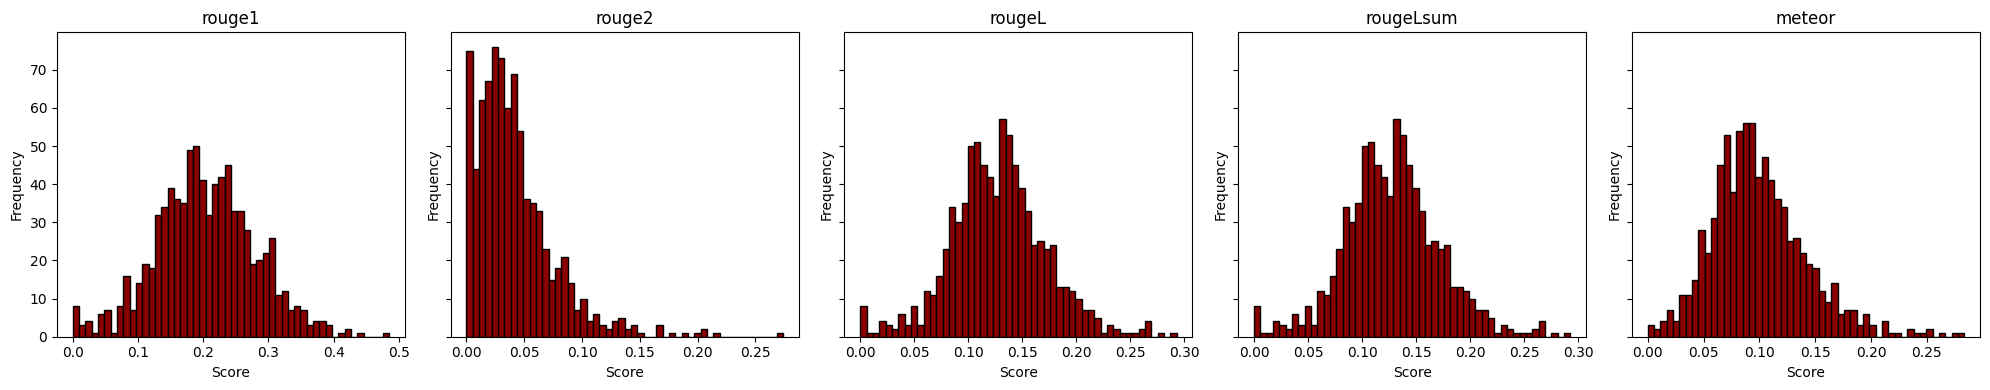

In [ ]:
# Baseline Rouge/Meteor Distributions

df_baseline_evals = df_baseline_meteor_rouge.drop(columns=['GeneratedText', 'ReferenceText'])

fig, axs = plt.subplots(1, 5, figsize=(20, 4), sharey=True)

for i, col in enumerate(df_baseline_evals.columns):
    axs[i].hist(df_baseline_evals[col], bins=50, color='darkred', edgecolor='black')  # Adjust bins as needed
    axs[i].set_title(col)
    axs[i].set_xlabel('Score')
    axs[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

# THESE ARE JUST RESULTS FOR 50 ROWS FROM TEST SET

In [ ]:
df_finetuned_rouge = calculate_model_rouge_scores(finetuned_df)
df_finetuned_meteor_rouge = calculate_model_meteor_scores(df_finetuned_rouge)
df_finetuned_meteor_rouge.head()

Start Time: 2024-07-29 19:42:10.752892-04:00
Complete. Time Taken: 00:02:47
Start Time: 2024-07-29 19:44:58.699606-04:00


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Complete. Time Taken: 00:00:15


,GeneratedText,ReferenceText,rouge1,rouge2,rougeL,rougeLsum,meteor
0,"[""The Web Processing Service Birdhouse (WPS Bi...",Birdhouse is a collaborative project open for ...,0.309013,0.034632,0.180258,0.180258,0.136272
1,['The aim of this study was to investigate the...,"Modern plant phenotyping, often using non-inva...",0.298319,0.071730,0.155462,0.155462,0.122405
2,['The aim of this study was to investigate the...,This paper aims to explore the role of sustain...,0.235589,0.065491,0.185464,0.185464,0.076522
3,['The failure of some populations and ecosyste...,Background: Predicting and abating the loss of...,0.284382,0.028103,0.153846,0.153846,0.140878
4,['Environmental exposures (ExO) are an importa...,E nvironmental health information resources la...,0.298734,0.081425,0.172152,0.172152,0.107759


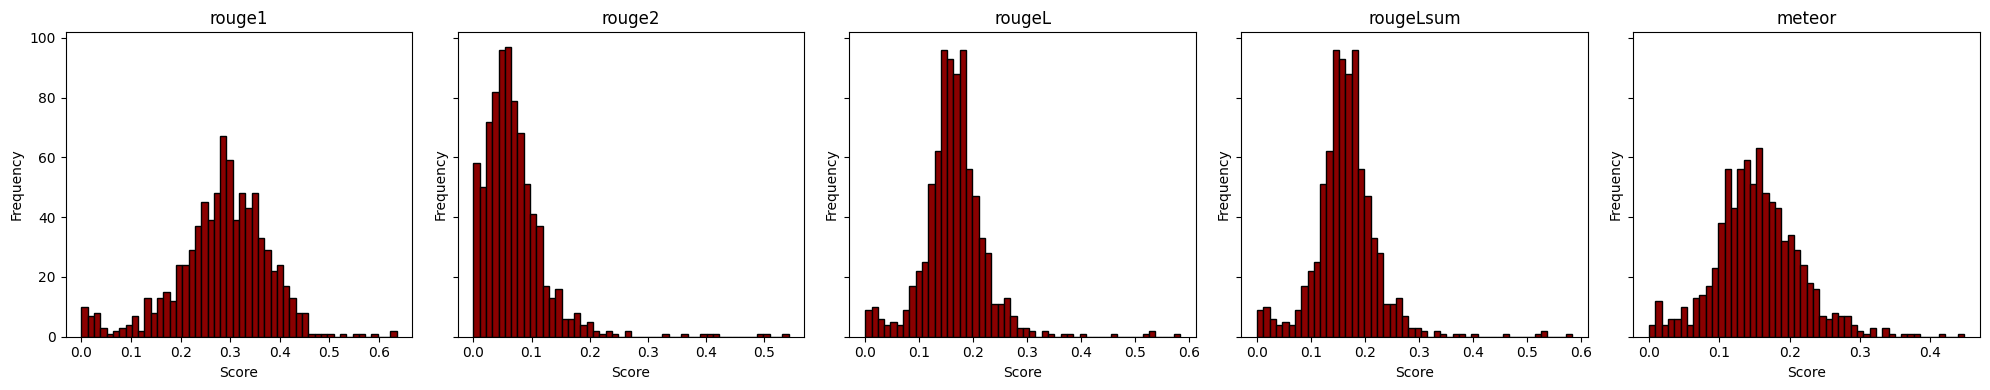

In [ ]:
# Finetuned Rouge/Meteor Distributions

df_finetuned_evals = df_finetuned_meteor_rouge.drop(columns=['GeneratedText', 'ReferenceText'])

fig, axs = plt.subplots(1, 5, figsize=(20, 4), sharey=True)

for i, col in enumerate(df_finetuned_evals.columns):
    axs[i].hist(df_finetuned_evals[col], bins=50, color='darkred', edgecolor='black')  # Adjust bins as needed
    axs[i].set_title(col)
    axs[i].set_xlabel('Score')
    axs[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

# THESE ARE JUST RESULTS FOR 50 ROWS FROM TEST SET

In [ ]:
# Aggregated Rouge/Meteor Scores

df_baseline_agg = df_baseline_meteor_rouge[['rouge1', 'rouge2', 'rougeL', 'rougeLsum', 'meteor']].mean().to_frame().T
df_finetuned_agg = df_finetuned_meteor_rouge[['rouge1', 'rouge2', 'rougeL', 'rougeLsum', 'meteor']].mean().to_frame().T

df_agg = pd.concat([df_baseline_agg, df_finetuned_agg])
df_agg.insert(loc=0, column='model', value=['Pegasus Baseline', 'Pegasus Finetuned'])
df_agg

,model,rouge1,rouge2,rougeL,rougeLsum,meteor
0,Pegasus Baseline,0.203752,0.041504,0.127752,0.127752,0.099223
0,Pegasus Finetuned,0.283817,0.069719,0.164813,0.164813,0.154508
